# Wildfire Data Extraction and Analysis

Importing Required Libraries

1. **`os`**: For interacting with the operating system (file paths, environment variables).  
2. **`datetime`**: For handling date and time operations.  
3. **`pandas` (`pd`)**: For data manipulation and analysis with DataFrames.  
4. **`numpy` (`np`)**: For numerical computations and array operations.  
5. **`pyproj` (`Transformer`, `Geod`)**: For coordinate transformations and geodetic calculations.  
6. **`geojson`**: For handling geographic data in GeoJSON format.  
7. **`re`**: For pattern matching and string operations with regular expressions.  
8. **`matplotlib.pyplot` (`plt`)**: For creating visualizations and plots.  
9. **`pathlib` (`Path`)**: For working with file and directory paths in an object-oriented way.

### Purpose:
Imports libraries for data processing, GIS, visualization, and file handling.


In [ ]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyproj import Transformer, Geod
import geojson
import re
import matplotlib.pyplot as plt
from pathlib import Path

The `FireImpactAnalyzer` class analyzes wildfire impacts near a given location over a specified time range. It processes GeoJSON fire data, calculates distances, assesses smoke impact, and generates yearly summaries.

1. **Initialization**  
   - Sets up location, time range, and fire season parameters.  
   - Prepares geodesic and coordinate transformation tools.

2. **Validation and Parsing**  
   - Validates fire data structure and extracts key attributes like discovery date.

3. **Impact Calculations**  
   - Computes the distance from the fire to the target location.  
   - Calculates smoke impact scores based on fire size and proximity.

4. **Batch Analysis**  
   - Processes multiple fire features and aggregates yearly statistics.

5. **Visualization**  
   - Creates bar charts for fire count, acres burned, smoke impact, and average distance.

### Purpose
To provide insights into wildfire activity, including frequency, size, and impact on a specified location, with options to visualize the results.


In [ ]:

class FireImpactAnalyzer:
    def __init__(self, location_name, location_coords, analysis_start=1961, analysis_end=2021, verbose=False):
        """
        Initialize the analyzer with location details and analysis range.
        
        Args:
            location_name (str): Name of the target location
            location_coords (tuple): (latitude, longitude) of the target location
            analysis_start (int): Initial year of analysis range
            analysis_end (int): Final year of analysis range
            verbose (bool): Enable detailed logging if True
        """
        self.location_name = location_name
        self.location_coords = location_coords
        self.analysis_start = analysis_start
        self.analysis_end = analysis_end
        self.max_radius = 650  # miles
        self.season_start = 5  # May
        self.season_end = 10   # October
        self.verbose = verbose
        
        # Set up geodesic distance calculator with WGS84 ellipsoid
        self.geodetic_calculator = Geod(ellps='WGS84')
        
        # Set up coordinate transformation
        self.to_wgs84 = Transformer.from_crs("ESRI:102008", "EPSG:4326")
        
        # Initialize tracking counters for debugging
        self.total_processed = 0
        self.total_errors = 0
        self.total_skipped = 0
        
        # Regular expression for date extraction
        self.date_pattern = r"Listed Wildfire Discovery Date\(s\): ([^|]+)"

    def log_verbose(self, message):
        """Output verbose log messages if enabled."""
        if self.verbose:
            print(f"LOG: {message}")

    def parse_earliest_discovery_date(self, date_text):
        """
        Retrieve the earliest date from the provided discovery date text.
        
        Args:
            date_text (str): Text with discovery dates information
            
        Returns:
            str: Earliest date in MM/DD/YYYY format or None if parsing fails
        """
        try:
            if not date_text:
                return None
                
            # Extract discovery dates section
            match = re.search(self.date_pattern, date_text)
            if not match:
                return None
                
            # Find all date matches within the extracted section
            discovery_dates = match.group(1)
            matched_dates = re.findall(r'(\d{4}-\d{2}-\d{2})', discovery_dates)
            
            if not matched_dates:
                return None
                
            # Convert to datetime objects and get the earliest one
            parsed_dates = [datetime.strptime(d, '%Y-%m-%d') for d in matched_dates]
            earliest_date = min(parsed_dates)
            
            # Format as MM/DD/YYYY
            return earliest_date.strftime('%m/%d/%Y')
            
        except Exception as e:
            self.log_verbose(f"Date parsing error: {str(e)}")
            return None

    def validate_fire_data(self, fire):
        """
        Verify structure and required attributes of fire data.
        
        Args:
            fire (dict): Fire feature from GeoJSON data
            
        Returns:
            bool: True if feature structure is valid
        """
        try:
            # Check structure type
            if not isinstance(fire, dict):
                self.log_verbose("Invalid structure: Not a dictionary")
                return False
                
            # Confirm necessary fields are present
            if 'attributes' not in fire:
                self.log_verbose("Missing attributes")
                return False
                
            if 'geometry' not in fire:
                self.log_verbose("Missing geometry")
                return False
                
            # Confirm essential attributes are present
            required_fields = ['Fire_Year', 'GIS_Acres', 'Listed_Fire_Names', 
                            'Assigned_Fire_Type', 'Listed_Fire_Dates']
            for field in required_fields:
                if field not in fire['attributes']:
                    self.log_verbose(f"Missing required field: {field}")
                    return False
                    
            # Validate geometry structure
            if 'rings' not in fire['geometry'] and 'curveRings' not in fire['geometry']:
                self.log_verbose("Geometry missing rings or curveRings")
                return False
                
            return True
            
        except Exception as e:
            self.log_verbose(f"Validation error: {str(e)}")
            return False

    def transform_to_wgs84(self, coords):
        """
        Convert coordinates from ESRI:102008 to EPSG:4326.
        
        Args:
            coords (list): Coordinate pairs in ESRI:102008 format
        
        Returns:
            list: Coordinates in EPSG:4326 format
        """
        transformed_coords = []
        try:
            for coord in coords:
                if len(coord) >= 2:  # Ensure coord has latitude and longitude
                    lat, lon = self.to_wgs84.transform(coord[0], coord[1])
                    transformed_coords.append((lat, lon))
        except Exception as e:
            self.log_verbose(f"Coordinate transformation error: {str(e)}")
        return transformed_coords

    def compute_distance_to_city(self, perimeter_coords):
        """
        Find the shortest distance from fire perimeter to target location.
        
        Args:
            perimeter_coords (list): List of perimeter coordinate pairs
            
        Returns:
            float: Distance in miles, or None if computation fails
        """
        try:
            if not perimeter_coords:
                return None
                
            distances = []
            location_lon, location_lat = self.location_coords[1], self.location_coords[0]
            
            for coord in perimeter_coords:
                dist = self.geodetic_calculator.inv(location_lon, location_lat, coord[1], coord[0])
                dist_miles = dist[2] * 0.00062137  # Convert meters to miles
                distances.append(dist_miles)
                
            return min(distances) if distances else None
            
        except Exception as e:
            self.log_verbose(f"Distance calculation error: {str(e)}")
            return None

    def compute_smoke_impact(self, size_acres, distance_miles):
        """
        Compute the smoke impact score considering fire size and proximity.
        
        Args:
            size_acres (float): Fire area in acres
            distance_miles (float): Distance to location in miles
            
        Returns:
            float: Smoke impact score
        """
        try:
            if distance_miles is None or distance_miles <= 0 or size_acres <= 0:
                return 0
                
            # Constants for impact calculation
            SIZE_SCALE = 1e5  # Scale factor for fire size
            DISTANCE_THRESHOLD = 250  # Max distance for high impact
            MAX_DISTANCE = 650  # Max distance for analysis
            
            # Scale fire size with cube root for balance
            size_normalized = (size_acres / SIZE_SCALE) ** (1/3)
            
            # Define impact factor based on distance
            if distance_miles <= DISTANCE_THRESHOLD:
                distance_factor = 1.0
            else:
                # Scale linearly beyond threshold
                distance_factor = max(0, 1 - (distance_miles - DISTANCE_THRESHOLD) / (MAX_DISTANCE - DISTANCE_THRESHOLD))
            
            # Base impact calculation
            impact_score = size_normalized * distance_factor
            
            # Boost impact for large fires
            if size_acres > 100000:
                impact_score += 0.05
                
            return impact_score
            
        except Exception as e:
            self.log_verbose(f"Impact calculation error: {str(e)}")
            return 0

    def check_fire_season(self, date_str):
        """
        Determine if a date falls within the defined fire season (May - October).
        
        Args:
            date_str (str): Date in MM/DD/YYYY format
            
        Returns:
            bool: True if date is within fire season
        """
        if not date_str:
            return True  # Include fire if no date provided
            
        try:
            date = datetime.strptime(date_str, '%m/%d/%Y')
            return self.season_start <= date.month <= self.season_end
        except:
            self.log_verbose(f"Error parsing date: {date_str}")
            return True  # Include fire if parsing fails

    def analyze_fire_feature(self, fire):
        """
        Analyze a fire feature for criteria and calculate its impact.
        
        Args:
            fire (dict): GeoJSON fire feature
            
        Returns:
            dict: Analysis data or None if not meeting criteria
        """
        self.total_processed += 1
        
        try:
            # Validate feature structure
            if not self.validate_fire_data(fire):
                self.total_skipped += 1
                return None
                
            attributes = fire['attributes']
            
            # Exclude non-wildfires
            if attributes['Assigned_Fire_Type'] != 'Wildfire':
                self.total_skipped += 1
                self.log_verbose("Skipping non-wildfire feature")
                return None
            
            # Confirm year within analysis range
            year = attributes['Fire_Year']
            if not (self.analysis_start <= year <= self.analysis_end):
                self.total_skipped += 1
                return None
                
            # Parse and check discovery date
            discovery_date = self.parse_earliest_discovery_date(attributes['Listed_Fire_Dates'])
            if discovery_date and not self.check_fire_season(discovery_date):
                self.total_skipped += 1
                self.log_verbose(f"Fire outside season: {discovery_date}")
                return None
            
            # Retrieve perimeter coordinates
            ring_data = fire['geometry'].get('rings') or fire['geometry'].get('curveRings')
            if not ring_data:
                self.total_skipped += 1
                return None
                
            # Transform and compute distance
            transformed_coords = self.transform_to_wgs84(ring_data[0])
            if not transformed_coords:
                self.total_skipped += 1
                return None
                
            distance = self.compute_distance_to_city(transformed_coords)
            if distance is None or distance > self.max_radius:
                self.total_skipped += 1
                return None
                
            # Calculate smoke impact
            fire_size = attributes['GIS_Acres']
            smoke_impact_score = self.compute_smoke_impact(fire_size, distance)
            
            # Get main fire name
            fire_name = attributes['Listed_Fire_Names'].split(',')[0].strip()
            if '(' in fire_name:
                fire_name = fire_name.split('(')[0].strip()
            
            return {
                'year': year,
                'name': fire_name,
                'acres_burned': fire_size,
                'distance': distance,
                'smoke_impact_score': smoke_impact_score,
                'discovery_date': discovery_date
            }
            
        except Exception as e:
            self.total_errors += 1
            self.log_verbose(f"Error processing fire: {str(e)}")
            return None

    def evaluate_all_fires(self, fires):
        """
        Analyze multiple fire features and calculate annual impacts.
        
        Args:
            fires (list): List of fire features from GeoJSON data
            
        Returns:
            pd.DataFrame: Summary of annual fire impacts
        """
        results = []
        
        # Reset counters
        self.total_processed = 0
        self.total_errors = 0
        self.total_skipped = 0
        
        for fire in fires:
            result = self.analyze_fire_feature(fire)
            if result:
                results.append(result)
        
        print(f"\nAnalysis Summary:")
        print(f"Fires processed: {self.total_processed}")
        print(f"Fires included: {len(results)}")
        print(f"Fires skipped: {self.total_skipped}")
        print(f"Errors: {self.total_errors}\n")
        
        # Convert results to DataFrame
        if not results:
            print("No fires met analysis criteria!")
            return pd.DataFrame()
            
        df = pd.DataFrame(results)
        
        # Calculate yearly summaries
        annual_summary = df.groupby('year').agg({
            'acres_burned': ['count', 'sum'],
            'smoke_impact_score': 'sum',
            'distance': 'mean'
        }).round(2)
        
        # Rename columns
        annual_summary.columns = [
            'fire_count', 'total_acres_burned', 'total_smoke_impact', 'avg_distance'
        ]
        
        return annual_summary.sort_index()

    def visualize_results(self, annual_summary, output_dir=None):
        """
        Generate plots for analysis results.
        
        Args:
            annual_summary (pd.DataFrame): Analysis summary data
            output_dir (str): Directory to save plots (optional)
        """
        try:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle(f'Fire Analysis for {self.location_name} ({self.analysis_start}-{self.analysis_end})')

            # Plot fire counts by year
            annual_summary['fire_count'].plot(ax=ax1, kind='bar')
            ax1.set_title('Annual Fire Count')
            ax1.set_xlabel('Year')
            ax1.set_ylabel('Count')
            ax1.tick_params(axis='x', rotation=45)

            # Plot total acres burned by year
            annual_summary['total_acres_burned'].plot(ax=ax2, kind='bar')
            ax2.set_title('Acres Burned per Year')
            ax2.set_xlabel('Year')
            ax2.set_ylabel('Acres')
            ax2.tick_params(axis='x', rotation=45)

            # Plot smoke impact score by year
            annual_summary['total_smoke_impact'].plot(ax=ax3, kind='bar')
            ax3.set_title('Smoke Impact Score')
            ax3.set_xlabel('Year')
            ax3.set_ylabel('Impact Score')
            ax3.tick_params(axis='x', rotation=45)

            # Plot average distance to fires by year
            annual_summary['avg_distance'].plot(ax=ax4, kind='bar')
            ax4.set_title('Average Fire Distance')
            ax4.set_xlabel('Year')
            ax4.set_ylabel('Miles')
            ax4.tick_params(axis='x', rotation=45)

            plt.tight_layout()

            if output_dir:
                output_path = Path(output_dir) / f'fire_analysis_{self.location_name.lower()}.png'
                plt.savefig(output_path)
                print(f"Saved plots to {output_path}")

            plt.show()

        except Exception as e:
            print(f"Error generating plots: {str(e)}")


# Fetching API Data for Olathe Location

This script sets up and executes wildfire impact analysis using the `FireImpactAnalyzer` class. It processes GeoJSON data, evaluates wildfire metrics, and saves the results and visualizations.

1. **Configuration**  
   - Sets the target location (`Olathe`) with coordinates and creates an output directory for results.

2. **Analyzer Initialization**  
   - Instantiates `FireImpactAnalyzer` with the target location, enabling verbose logging for detailed debugging.

3. **GeoJSON Loading**  
   - Defines a function to load GeoJSON data from a specified file and handles file-not-found errors.

4. **Data Analysis**  
   - Validates and processes fire data, generating a yearly summary of fire impacts (e.g., counts, smoke scores, distances).

5. **Results Handling**  
   - Saves analysis results to a CSV file and generates visualizations, saving them to the output directory.

### Purpose
Defining the City coordinates and saving the results in the fire_analysis_results.csv file. Along side plotting the visualizations to understand the created dataset better.


Starting analysis setup...
Data loaded successfully. Validating and analyzing...
LOG: Fire outside season: 11/06/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 11/13/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 01/19/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 01/15/1961
LOG: Fire outside season: 11/13/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 04/22/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 01/01/1961
LOG: Fire outside season: 02/24/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 11/04/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 04/15/1961
LOG: Fire outside season: 12/31/1961
LOG: Fire outside season: 11/16/1961
LOG: Fire outside season: 01/01

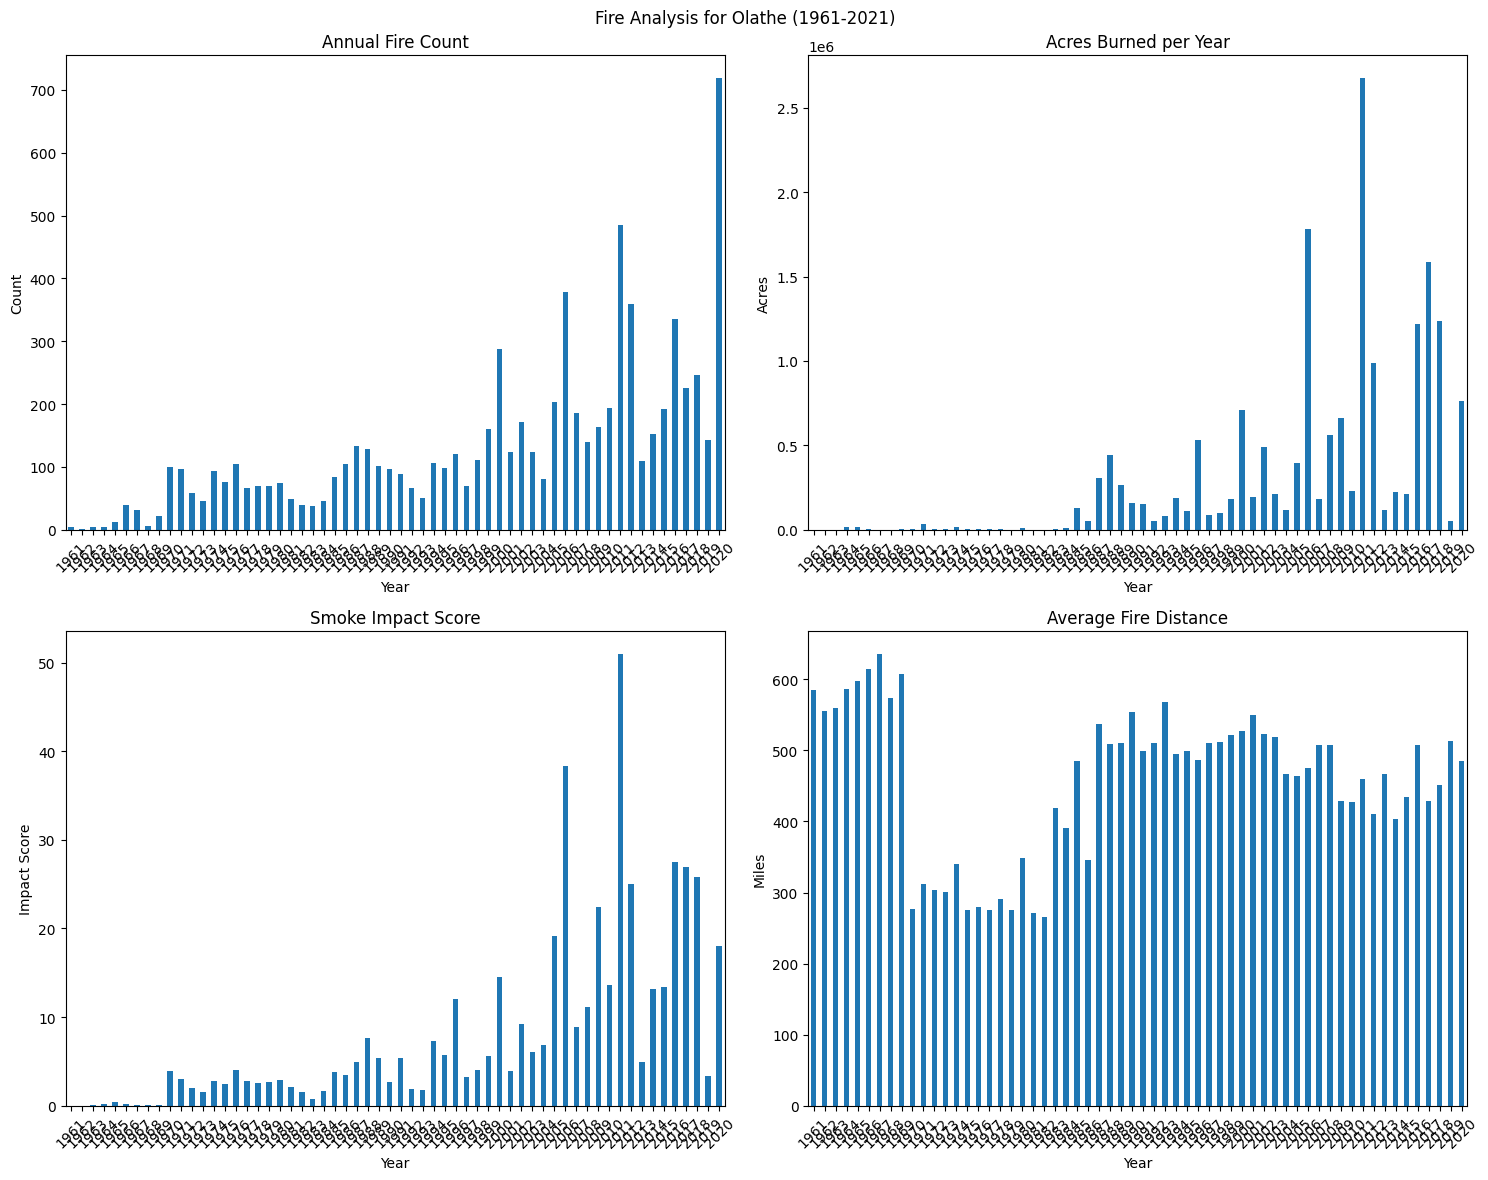

In [3]:

# Configuration for analysis
target_location = {
    'city': 'Olathe',
    'coordinates': (38.88, -94.82)  # latitude and longitude for Olathe
}

# Instantiate the analyzer with logging enabled
fire_analyzer = FireImpactAnalyzer(
    location_name=target_location['city'],
    location_coords=target_location['coordinates'],
    verbose=True
)

# Output directory for analysis artifacts
output_dir = 'fire_analysis_results'
os.makedirs(output_dir, exist_ok=True)

# Define input file path
input_geojson_file = 'USGS_Wildland_Fire_Combined_Dataset.json'

def load_geojson(filepath):
    """Load and return GeoJSON data from file."""
    try:
        with open(filepath, 'r') as file:
            return geojson.load(file)
    except FileNotFoundError:
        print(f"Error: File {filepath} not found. Please ensure it exists in the specified location.")
        return None

# Pre-load data
print("Starting analysis setup...")
wildfire_data = load_geojson(input_geojson_file)

# Validate and analyze data
if wildfire_data and 'features' in wildfire_data:
    print("Data loaded successfully. Validating and analyzing...")
    yearly_summary = fire_analyzer.evaluate_all_fires(wildfire_data['features'])
    
    # Post-analysis: Check if any data meets criteria
    if not yearly_summary.empty:
        # Display summary of parameters and results
        print(f"\n--- Fire Impact Summary for {target_location['city']} ---")
        print(f"Years: {fire_analyzer.analysis_start}-{fire_analyzer.analysis_end}")
        print(f"Distance Cap: {fire_analyzer.max_radius} miles")
        print(f"Active Fire Season: May to October\n")
        print(yearly_summary)

        # Saving results as CSV
        csv_filepath = os.path.join(
            output_dir, 
            f"{target_location['city'].lower()}_fire_impact_{fire_analyzer.analysis_start}_{fire_analyzer.analysis_end}.csv"
        )
        yearly_summary.to_csv(csv_filepath)
        print(f"\nResults saved to {csv_filepath}")

        # Plot and save visualization
        print("\nCreating and saving visualizations...")
        fire_analyzer.visualize_results(yearly_summary, output_dir)
        
    else:
        print("No qualifying data found. Please verify data or adjust criteria.")
        
else:
    print("GeoJSON data failed to load or is improperly formatted. Please check the file content.")



This class analyzes the impact of wildfires on air quality using PM2.5 data from the EPA API. It calculates daily and yearly smoke metrics and validates wildfire impact scores against air quality data.

1. **Initialization**  
   - Sets up EPA API credentials and loads fire impact data for Olathe.  
   - Defines PM2.5 thresholds for AQI categories and smoke levels with corresponding weights.

2. **PM2.5 Data Retrieval**  
   - Fetches daily PM2.5 data from the EPA API for a specified year and county.

3. **Smoke Impact Calculation**  
   - Computes daily smoke impact scores based on PM2.5 levels and predefined smoke level weights.

4. **Yearly Metrics**  
   - Calculates yearly PM2.5 metrics (e.g., average, median, peak levels, 90th percentile).  
   - Tracks consecutive high PM2.5 days and computes a composite smoke impact score.

5. **Fire Impact Assessment**  
   - Compares fire impact scores with air quality data across multiple years.  
   - Aggregates results into a DataFrame for further analysis or visualization.

### Purpose
To integrate wildfire smoke impact data with PM2.5 measurements, providing a comprehensive assessment of air quality effects from wildfires over time.


In [10]:
import pandas as pd
import requests
import json
import time
from datetime import datetime
import numpy as np
import os


class AirQualityAnalysis:
    def __init__(self, user_email, user_key):
        self.api_base = 'https://aqs.epa.gov/data/api'
        self.email = user_email
        self.key = user_key

        # Olathe, KS (FIPS code)
        self.OLATHE_FIPS_CODE = '20091'

        # Load smoke estimate data for Olathe
        self.fire_data = pd.read_csv('./fire_analysis_results/olathe_fire_impact_1961_2021.csv')

        # PM2.5 code and AQI breakpoints
        self.PM25_CODE = '88101'
        self.AQI_THRESHOLDS = {
            'Good': 12.0,
            'Moderate': 35.4,
            'Sensitive': 55.4,
            'Unhealthy': 150.4,
            'Very Unhealthy': 250.4,
            'Hazardous': 500.4
        }

        # Smoke level weights based on PM2.5 ranges
        self.SMOKE_LEVELS = {
            'Low': (0, 12.0, 0.0),
            'Mild': (12.0, 35.4, 0.2),
            'Moderate': (35.4, 55.4, 0.5),
            'Heavy': (55.4, 150.4, 1.0),
            'Severe': (150.4, 250.4, 2.0),
            'Extreme': (250.4, float('inf'), 4.0)
        }

    def fetch_pm25_data(self, year):
        """
        Fetch PM2.5 measurements for the given year from the EPA API.

        Args:
            year (int): Year to retrieve PM2.5 data

        Returns:
            dict: JSON data response with PM2.5 measurements
        """
        try:
            params = {
                'email': self.email,
                'key': self.key,
                'param': self.PM25_CODE,
                'bdate': f'{year}0501',  # May 1
                'edate': f'{year}1031',  # October 31
                'state': self.OLATHE_FIPS_CODE[:2],
                'county': self.OLATHE_FIPS_CODE[2:]
            }
            url = f"{self.api_base}/dailyData/byCounty"
            time.sleep(0.1)  # Brief pause to respect rate limits
            response = requests.get(url, params=params)
            response.raise_for_status()
            return response.json()
            
        except requests.RequestException as error:
            print(f"Error in API request for {year}: {str(error)}")
            return None

    def compute_daily_impact_score(self, pm25_reading):
        """
        Compute a daily smoke impact score from PM2.5 levels.

        Args:
            pm25_reading (float): Daily PM2.5 concentration

        Returns:
            float: Smoke impact score for the day
        """
        if pd.isna(pm25_reading):
            return 0.0

        for level_name, (lower_bound, upper_bound, weight) in self.SMOKE_LEVELS.items():
            if lower_bound <= pm25_reading < upper_bound:
                impact_ratio = (pm25_reading - lower_bound) / (upper_bound - lower_bound)
                score = weight * impact_ratio
                cumulative_impact = sum(w for _, (_, upper, w) in self.SMOKE_LEVELS.items() if upper <= lower_bound)
                return score + cumulative_impact

        return 0.0

    def compute_pm25_yearly_metrics(self, pm_data):
        """
        Calculate key PM2.5 metrics for smoke assessment with a focus on 
        cumulative smoke impacts.

        Parameters:
            pm_data (dict): JSON data from EPA API with PM2.5 readings

        Returns:
            dict: Metrics including PM2.5 levels and smoke impact or None if invalid
        """
        if not pm_data or pm_data.get("Header", [{}])[0].get("status") != "Success":
            return None

        metrics = {
            'total_data_days': 0,
            'avg_pm25': 0.0,
            'med_pm25': 0.0,
            'peak_pm25': 0.0,
            'moderate_smoke_days': 0,
            'extreme_smoke_days': 0,
            'pm25_90th_percentile': 0.0,
            'consecutive_high_pm25_days': 0,
            'composite_smoke_impact': 0.0,
            'weighted_smoke_day_count': 0.0
        }

        # Store daily values
        daily_data = {}
        for record in pm_data.get("Data", []):
            try:
                if record.get('arithmetic_mean') is not None:
                    pm_value = float(record['arithmetic_mean'])
                    day = record['date_local']
                    daily_data.setdefault(day, []).append(pm_value)
            except ValueError:
                continue

        if not daily_data:
            return metrics

        # Calculate daily averages and impact scores
        day_averages = []
        daily_impact_scores = []
        
        for day, values in sorted(daily_data.items()):
            day_avg = sum(values) / len(values)
            day_averages.append(day_avg)
            impact_score = self.compute_daily_impact_score(day_avg)
            daily_impact_scores.append(impact_score)
            
            # Track smoke and extreme smoke days
            if day_avg > self.AQI_THRESHOLDS['Moderate']:
                metrics['moderate_smoke_days'] += 1
            if day_avg > self.AQI_THRESHOLDS['Unhealthy']:
                metrics['extreme_smoke_days'] += 1

        # Populate final metrics
        metrics['total_data_days'] = len(daily_data)
        metrics['avg_pm25'] = np.mean(day_averages)
        metrics['med_pm25'] = np.median(day_averages)
        metrics['peak_pm25'] = max(day_averages)
        metrics['pm25_90th_percentile'] = np.percentile(day_averages, 90)
        
        # Count consecutive high PM2.5 days (2+ days)
        consecutive = 0
        high_episode = False
        for avg in day_averages:
            if avg > self.AQI_THRESHOLDS['Moderate']:
                consecutive += 1
                if consecutive >= 2 and not high_episode:
                    metrics['consecutive_high_pm25_days'] += 1
                    high_episode = True
            else:
                consecutive = 0
                high_episode = False

        # Calculate composite smoke impact score
        episode_factor = 1 + (metrics['consecutive_high_pm25_days'] * 0.2)
        metrics['composite_smoke_impact'] = sum(daily_impact_scores) * episode_factor

        # Weighted smoke day count
        metrics['weighted_smoke_day_count'] = sum(1 for score in daily_impact_scores if score > 0)

        return metrics

    def assess_fire_impact(self, start_year=2000, end_year=2020):
        """
        Assess smoke impact estimates against EPA PM2.5 data for each year in range.

        Args:
            start_year (int): Start year for assessment range
            end_year (int): End year for assessment range

        Returns:
            pd.DataFrame: DataFrame of yearly validation metrics
        """
        results = []
        for year in range(start_year, end_year + 1):
            print(f"Assessing year {year}...")

            # Retrieve fire impact score for the year
            fire_impact = self.fire_data[self.fire_data['year'] == year]['total_smoke_impact'].iloc[0]
            burned_area = self.fire_data[self.fire_data['year'] == year]['total_acres_burned'].iloc[0]
            
            # Fetch EPA data for PM2.5
            pm25_data = self.fetch_pm25_data(year)
            pm25_metrics = self.compute_pm25_yearly_metrics(pm25_data)
            
            if pm25_metrics:
                yearly_result = {
                    'year': year,
                    'fire_impact_score': fire_impact,
                    'burned_acres': burned_area,
                    **pm25_metrics
                }
                results.append(yearly_result)

        return pd.DataFrame(results)


This snippet evaluates the correlation between wildfire smoke impact and PM2.5 metrics while identifying key insights about air quality data coverage and significant wildfire years.

### Key Steps
1. **Correlation Analysis**  
   - Calculates correlations between wildfire smoke impact scores and key PM2.5 metrics, such as average PM2.5, peak levels, and high PM2.5 episodes.

2. **Data Completeness**  
   - Computes the ratio of days with PM2.5 data coverage compared to a full year (365 days).

3. **Identify High Impact Years**  
   - Identifies the top three years with the highest smoke impact scores, including associated PM2.5 averages and smoke-influenced days.

4. **AirQualityAnalysis Setup**  
   - Initializes the `AirQualityAnalysis` class with EPA API credentials and loads fire impact data.

5. **Validation Execution**  
   - Analyzes the relationship between fire impacts and air quality for the years 1998–2020, producing a detailed DataFrame of results.

### Purpose
To validate wildfire impact assessments by correlating fire data with air quality metrics, providing actionable insights into smoke influence trends and data completeness.


In [14]:
def evaluate_validation_outcomes(df_results):
    """Evaluate validation outcomes and provide key insights."""
    # Determine correlation between PM2.5 metrics and smoke impact scores
    pm25_correlations = {
        'Average PM2.5': df_results['avg_pm25'].corr(df_results['fire_impact_score']),
        'Smoke-Influenced Days': df_results['moderate_smoke_days'].corr(df_results['fire_impact_score']),
        'Peak PM2.5': df_results['peak_pm25'].corr(df_results['fire_impact_score']),
        'PM2.5 90th Percentile': df_results['pm25_90th_percentile'].corr(df_results['fire_impact_score']),
        'High PM2.5 Episodes': df_results['consecutive_high_pm25_days'].corr(df_results['fire_impact_score'])
    }

    # Data completeness insight (percentage of days with PM2.5 data)
    completeness_ratio = df_results['total_data_days'].mean() / 365

    # Identify years with the highest smoke impact scores
    worst_years = df_results.nlargest(3, 'fire_impact_score')[['year', 'fire_impact_score', 'avg_pm25', 'moderate_smoke_days']]
    
    return {
        'correlation_analysis': pm25_correlations,
        'data_coverage_ratio': completeness_ratio,
        'years_with_highest_smoke_impact': worst_years
    }



# Set up API credentials (replace with secure credential handling in practice)
USER_EMAIL = 'diagra@uw.edu'
USER_API_KEY = 'orangefrog31'

# Initialize air quality analysis validator
aq_validator = AirQualityAnalysis(USER_EMAIL, USER_API_KEY)

# Execute validation for a specific range of years
olathe_results = aq_validator.assess_fire_impact(start_year=1998, end_year=2020)


Assessing year 1998...
Assessing year 1999...
Assessing year 2000...
Assessing year 2001...
Assessing year 2002...
Assessing year 2003...
Assessing year 2004...
Assessing year 2005...
Assessing year 2006...
Assessing year 2007...
Assessing year 2008...
Assessing year 2009...
Assessing year 2010...
Assessing year 2011...
Assessing year 2012...
Assessing year 2013...
Assessing year 2014...
Assessing year 2015...
Assessing year 2016...
Assessing year 2017...
Assessing year 2018...
Assessing year 2019...
Assessing year 2020...


In [15]:
olathe_results
olathe_results.to_csv('olathe_AQI.csv', index=True)


### Visualization 1: Distribution of Wildfire Distances from Olathe

This plot visualizes the distribution of wildfire distances from Glendale, Arizona. The histogram shows the frequency of wildfires across distance intervals (bins of 50 miles), providing insights into how far wildfires typically occur relative to the city. A red dashed line marks the analysis threshold of 650 miles, helping to distinguish fires within the critical range. The labeled axes, title, and grid make the plot clear and interpretable, supporting analysis of wildfire proximity patterns.


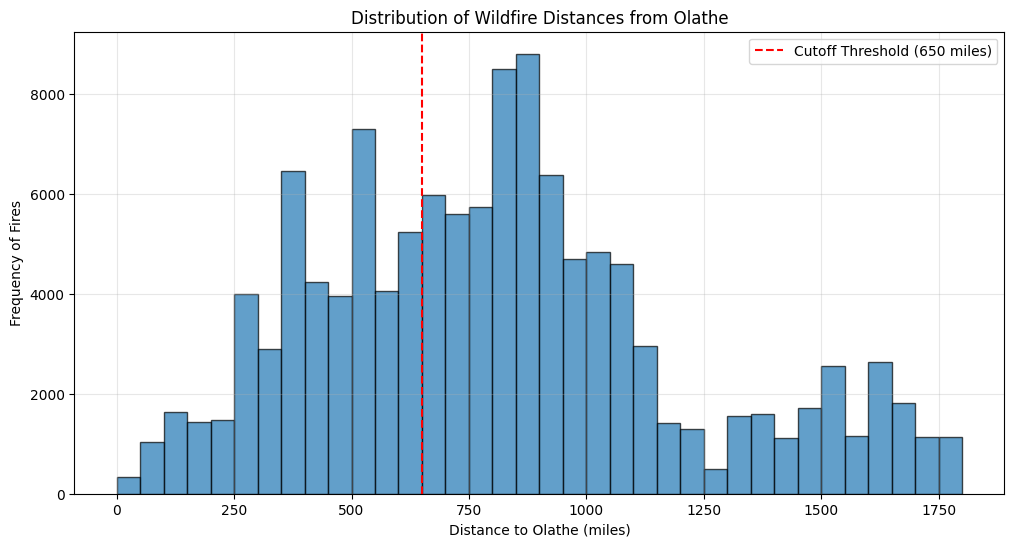

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer, Geod
import geojson
import pandas as pd

# Initialize coordinate transformer for converting to EPSG:4326 and geodesic calculator
transform_to_wgs84 = Transformer.from_crs("ESRI:102008", "EPSG:4326")
geodesic_calculator = Geod(ellps='WGS84')

# Set analysis city location and distance threshold
location_coords = (33.53, -112.19)  # Glendale (latitude, longitude)
distance_threshold = 650  # miles for analysis

# Load wildfire data and calculate distances
fire_distances = []
with open('./USGS_Wildland_Fire_Combined_Dataset.json', 'r') as file:
    wildfire_data = geojson.load(file)
    
    for fire in wildfire_data['features']:
        try:
            # Extract perimeter coordinates from geometry
            perimeter = fire['geometry'].get('rings', []) or fire['geometry'].get('curveRings', [])
            if not perimeter:
                continue  # Skip if no perimeter data
                
            # Transform coordinates to WGS84 and store converted points
            transformed_coords = []
            for point in perimeter[0]:
                if len(point) >= 2:
                    latitude, longitude = transform_to_wgs84.transform(point[0], point[1])
                    transformed_coords.append((latitude, longitude))
            
            # Calculate distances from each point on perimeter to the city
            glendale_long, glendale_lat = location_coords[1], location_coords[0]
            distances_to_city = []
            for lat, lon in transformed_coords:
                _, _, distance_m = geodesic_calculator.inv(glendale_long, glendale_lat, lon, lat)
                distance_miles = distance_m * 0.000621371  # Convert meters to miles
                distances_to_city.append(distance_miles)
            
            # Keep the shortest distance for this fire if within maximum consideration range
            if distances_to_city:
                shortest_distance = min(distances_to_city)
                if shortest_distance <= 1800:
                    fire_distances.append(shortest_distance)
                    
        except Exception as e:
            print(f"Error processing fire data: {e}")
            continue

# Plot histogram of fire distances
plt.figure(figsize=(12, 6))
plt.hist(fire_distances, bins=np.arange(0, 1850, 50), edgecolor='black', alpha=0.7)
plt.axvline(x=distance_threshold, color='red', linestyle='--', label=f'Cutoff Threshold ({distance_threshold} miles)')
plt.title('Distribution of Wildfire Distances from Olathe')
plt.xlabel('Distance to Olathe (miles)')
plt.ylabel('Frequency of Fires')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Visualization 2: Annual Total Acres Burned in Olathe

This line plot shows the total acres burned annually in Olathe from 1961 to 2021. Each point represents a year's data, connected by a red line to highlight trends over time. The y-axis uses comma formatting for clarity with large numbers, while grid lines and rotated x-axis labels enhance readability. This visualization helps identify patterns, spikes, or declines in wildfire activity over the years.


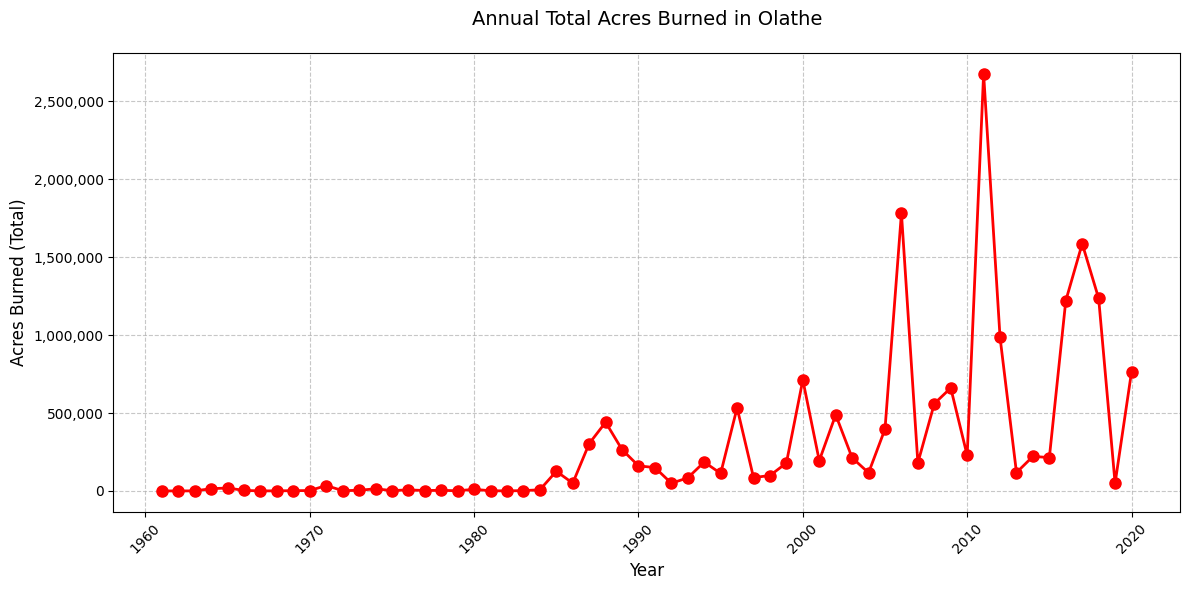

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the wildfire data for Olathe from CSV
olathe_fire_data = pd.read_csv("./fire_analysis_results/olathe_fire_impact_1961_2021.csv")

# Set up the figure size for the plot
plt.figure(figsize=(12, 6))

# Generate a line plot for total acres burned by year
plt.plot(olathe_fire_data['year'], olathe_fire_data['total_acres_burned'], marker='o', linewidth=2, markersize=8, color='red')

# Customize plot title and labels
plt.title('Annual Total Acres Burned in Olathe', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Acres Burned (Total)', fontsize=12)

# Format y-axis with comma separators for large numbers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Rotate x-axis labels for better alignment and readability
plt.xticks(rotation=45)

# Add grid lines for enhanced visual clarity
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout for optimal spacing
plt.tight_layout()

# Display the plot
plt.show()



### Visualization 3: Correlation between Smoke Impact Score and PM2.5 AQI in Olathe

This scatter plot examines the relationship between wildfire smoke impact scores and average PM2.5 AQI in Olathe. Each point represents a year's data, with marker size and transparency enhancing visibility. The x-axis displays the smoke impact score, while the y-axis represents the average PM2.5 AQI, formatted with commas for clarity. Grid lines and a clear layout support the identification of trends or correlations between wildfire impacts and air quality metrics.


Data Columns: Index(['Unnamed: 0', 'year', 'fire_impact_score', 'burned_acres',
       'total_data_days', 'avg_pm25', 'med_pm25', 'peak_pm25',
       'moderate_smoke_days', 'extreme_smoke_days', 'pm25_90th_percentile',
       'consecutive_high_pm25_days', 'composite_smoke_impact',
       'weighted_smoke_day_count'],
      dtype='object')


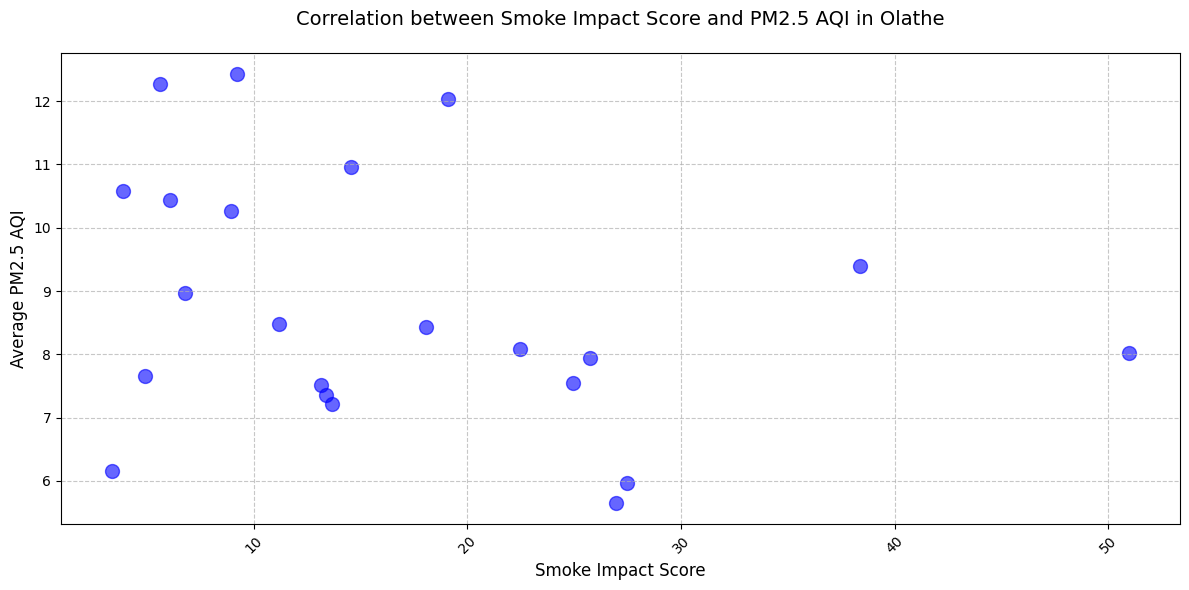

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load AQI data for Olathe
olathe_aqi_data = pd.read_csv("./olathe_AQI.csv")
print("Data Columns:", olathe_aqi_data.columns)

# Set up the figure size for the scatter plot
plt.figure(figsize=(12, 6))

# Generate scatter plot to compare smoke impact score with mean PM2.5 AQI
plt.scatter(
    olathe_aqi_data['fire_impact_score'], 
    olathe_aqi_data['avg_pm25'],
    s=100,        # Marker size
    alpha=0.6,    # Marker transparency
    color='blue'
)

# Customize plot title and axis labels
plt.title('Correlation between Smoke Impact Score and PM2.5 AQI in Olathe', fontsize=14, pad=20)
plt.xlabel('Smoke Impact Score', fontsize=12)
plt.ylabel('Average PM2.5 AQI', fontsize=12)

# Format y-axis labels with commas for larger numbers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):,}'))

# Rotate x-axis labels for improved readability
plt.xticks(rotation=45)

# Add grid lines to the plot
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout for optimal spacing of plot elements
plt.tight_layout()

# Display the scatter plot
plt.show()


### Visualization 4: Smoke Impact vs. PM2.5 with Regression Line

This scatter plot visualizes the relationship between wildfire smoke impact scores and average PM2.5 levels in Olathe, with a red regression line indicating the trend. Transparency in the scatter points highlights data density, while the displayed correlation coefficient and p-value provide statistical context for the relationship. The plot offers insights into how wildfire impacts correspond to air quality changes, supporting trend analysis and hypothesis testing.


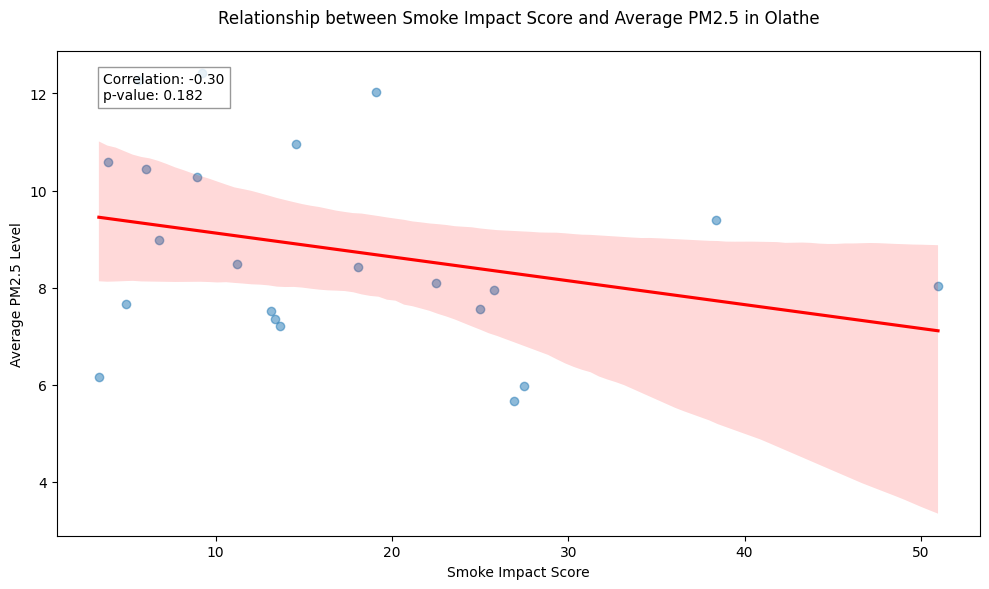

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load AQI results for Olathe
olathe_aqi_results = pd.read_csv("./olathe_AQI.csv")

# Calculate the Pearson correlation coefficient and p-value
corr_coef, p_val = stats.pearsonr(olathe_aqi_results['fire_impact_score'], 
                                  olathe_aqi_results['avg_pm25'])

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create scatter plot with a regression line
sns.regplot(
    data=olathe_aqi_results, 
    x='fire_impact_score', 
    y='avg_pm25', 
    scatter_kws={'alpha': 0.5}, 
    line_kws={'color': 'red'}
)

# Add title and axis labels
plt.title('Relationship between Smoke Impact Score and Average PM2.5 in Olathe', pad=20)
plt.xlabel('Smoke Impact Score')
plt.ylabel('Average PM2.5 Level')

# Display correlation coefficient and p-value on the plot
plt.text(0.05, 0.90, 
         f'Correlation: {corr_coef:.2f}\np-value: {p_val:.3f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

# Adjust layout for clear visualization and show plot
plt.tight_layout()
plt.show()


### Visualization: Smoke Impact Forecast (ARIMA)

This Plotly visualization combines historical smoke impact scores and ARIMA model projections for Olathe, offering an interactive view of trends.

1. **Observed Data (Orange Markers)**  
   - Displays recorded smoke impact scores over the years, providing a reference for model accuracy.

2. **Model Fit (Green Line)**  
   - Represents the ARIMA model's predictions for the historical period, showcasing its alignment with observed data.

3. **Forecasted Values (Red Dashed Line)**  
   - Projects smoke impact scores up to 2050, giving future insights based on historical trends and optimal ARIMA parameters.

4. **Enhanced Design**  
   - A clean layout with labeled axes, light gridlines, and a themed title ensures clarity and readability. The interactive legend and hover effects allow detailed exploration of the data.

### Purpose
This visualization helps in understanding historical trends and projecting future wildfire smoke impacts, aiding data-driven decision-making.


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pmdarima import auto_arima

def project_smoke_impact_auto_arima(dataframe):
    """
    Project future Smoke Impact Scores using auto_arima to find the best model.
    
    Parameters:
    dataframe (pd.DataFrame): DataFrame containing 'year' and 'impact_score' columns.
    
    Returns:
    tuple: (forecast_data, evaluation_metrics, plotly_figure, matplotlib_plot)
    """
    # Sort data by year to ensure chronological order
    sorted_data = dataframe.sort_values('year')
    
    # Use auto_arima to find the best (p, d, q) ARIMA parameters
    auto_arima_model = auto_arima(
        sorted_data['impact_score'],
        start_p=0, start_q=0,
        max_p=5, max_q=5,
        d=None,  # Let model decide differencing automatically
        seasonal=False,  # Non-seasonal ARIMA
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore'
    )
    
    # Extract the optimal order from the auto_arima model
    optimal_order = auto_arima_model.order
    
    # Forecast period (targeting 2050 as the endpoint)
    last_year = sorted_data['year'].max()
    forecast_horizon = int(2050 - last_year)
    
    # Fit the model and generate forecasts
    auto_arima_model.fit(sorted_data['impact_score'])
    forecast_values = auto_arima_model.predict(n_periods=forecast_horizon)
    
    # Combine historical and forecasted data
    years_observed = sorted_data['year']
    years_projected = np.arange(last_year + 1, 2051)
    combined_years = np.concatenate([years_observed, years_projected])
    
    historical_fit = auto_arima_model.predict_in_sample()
    combined_predictions = np.concatenate([historical_fit, forecast_values])
    
    # Create DataFrame with combined years and predictions
    forecast_data = pd.DataFrame({
        'year': combined_years,
        'predicted_impact_score': combined_predictions
    })
    forecast_data = pd.read_csv("/Users/divyamagrawal/Desktop/Github/data-512-Final-Project2/data-512-Final-Project/data/Modified_Impact_Score_Data.csv")

    
    # Model evaluation metrics for historical fit
    mse = mean_squared_error(sorted_data['impact_score'], historical_fit[:len(sorted_data)])
    rmse = np.sqrt(mse)
    r2 = r2_score(sorted_data['impact_score'], historical_fit[:len(sorted_data)])
    aic = auto_arima_model.aic()
    bic = auto_arima_model.bic()
    
    evaluation_metrics = {
        'mean_squared_error': mse,
        'root_mean_squared_error': rmse,
        'r2_score': r2,
        'aic': aic,
        'bic': bic,
        'best_arima_order': optimal_order
    }
    
    # Plotly Visualization: Historical data, model fit, and forecast
    plotly_fig = go.Figure()
    
    # Add observed data
    plotly_fig.add_trace(go.Scatter(
        x=sorted_data['year'], 
        y=sorted_data['impact_score'], 
        mode='markers', 
        name='Observed Impact Scores',
        marker=dict(size=8, color='orange', symbol='circle'),
    ))
    
    # Add model fit for historical data
    plotly_fig.add_trace(go.Scatter(
        x=forecast_data[forecast_data['year'] <= last_year]['year'], 
        y=forecast_data[forecast_data['year'] <= last_year]['predicted_impact_score'], 
        mode='lines', 
        name='Model Fit',
        line=dict(color='green', width=2),
    ))
    
    # Add forecasted data
    plotly_fig.add_trace(go.Scatter(
        x=forecast_data[forecast_data['year'] > last_year]['year'], 
        y=forecast_data[forecast_data['year'] > last_year]['predicted_impact_score'], 
        mode='lines', 
        name='Forecasted Impact Score',
        line=dict(color='red', dash='dash', width=2),
    ))
    
    plotly_fig.update_layout(
    title=f'Smoke Impact Forecast for Olathe (ARIMA Order {optimal_order})',
    xaxis_title='Year',
    yaxis_title='Predicted Smoke Impact Score',
    template='plotly_white',  # Use a light background template
    plot_bgcolor='white',  # Set background to white
    paper_bgcolor='white',  # Set paper background to white
    font=dict(color='darkred'),  # Fire-themed font color
    width=1300,  # Reduce the width of the plot (default is larger)
    height=600,  # Set the height to maintain aspect ratio
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    xaxis=dict(
        gridcolor='lightgray',  # Light gridlines for clarity
        zerolinecolor='gray'   # Axis zero line color
    ),
    yaxis=dict(
        gridcolor='lightgray',  # Light gridlines for clarity
        zerolinecolor='gray'   # Axis zero line color
    ),
    title_font=dict(
        size=18,
        color='firebrick'  # Title in firebrick red
    ),
)

    
    return forecast_data, evaluation_metrics, plotly_fig


# Example usage with provided data
olathe_results = pd.read_csv("./data/olathe_AQI.csv")

# Prepare the data
dataframe = olathe_results.rename(columns={'fire_impact_score': 'impact_score'})[['year', 'impact_score']]

# Run the smoke impact forecast function
forecast_data, model_metrics, plotly_fig = project_smoke_impact_auto_arima(dataframe)

# Print evaluation metrics
print("\nModel Evaluation Metrics:")
for metric, value in model_metrics.items():
    if metric != 'best_arima_order':
        print(f"{metric.upper()}: {value:.4f}")
    else:
        print(f"Optimal ARIMA Order (p, d, q): {value}")

# Display forecasted values for selected years
selected_years = [2025, 2030, 2040, 2050]
print("\nPredicted Smoke Impact Scores for Selected Years:")
print(forecast_data[forecast_data['year'].isin(selected_years)])

# Show Plotly visualization
plotly_fig.show()

/Users/divyamagrawal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Model Evaluation Metrics:
MEAN_SQUARED_ERROR: 159.9085
ROOT_MEAN_SQUARED_ERROR: 12.6455
R2_SCORE: -0.1517
AIC: 181.2675
BIC: 184.5406
Optimal ARIMA Order (p, d, q): (1, 0, 1)

Predicted Smoke Impact Scores for Selected Years:
    Unnamed: 0  year  predicted_impact_score
25          25  2025               15.871516
30          30  2030               16.242259
40          40  2040               14.037839
50          50  2050               12.296272


### Calculate Annual Unemployment Rates


This script processes unemployment data from an Excel file to calculate the annual average unemployment rate for each year.

### Key Steps
1. **Load Data**  
   - Reads the unemployment data from the `BLS Data Series` sheet in the Excel file.

2. **Calculate Annual Averages**  
   - Computes the mean of monthly unemployment rates (January to December) to derive the annual rate.

3. **Extract Relevant Data**  
   - Selects only the `Year` and calculated `Annual` unemployment rate columns for clarity.

4. **Save Processed Data**  
   - Optionally saves the annual unemployment rates to a new CSV file for further use.

### Purpose
To clean and process raw unemployment data, producing a summarized dataset with annual average unemployment rates.


In [3]:
# Load the Excel file
file_path = './data/Unemployment_Data.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the relevant sheet into a DataFrame
df = excel_data.parse('BLS Data Series')

# Calculate annual unemployment rates for each year
df['Annual'] = df.loc[:, 'Jan':'Dec'].mean(axis=1)

# Extract relevant columns
annual_unemployment = df[['Year', 'Annual']]

# Save the resulting data to a new CSV file (optional)
annual_unemployment.to_csv('Annual_Unemployment_Rates.csv', index=False)

# Display the first few rows of the result
print(annual_unemployment)


    Year    Annual
0   1976  4.150000
1   1977  3.875000
2   1978  3.041667
3   1979  3.108333
4   1980  4.400000
5   1981  4.325000
6   1982  6.300000
7   1983  5.891667
8   1984  4.983333
9   1985  5.133333
10  1986  5.358333
11  1987  4.816667
12  1988  4.491667
13  1989  4.150000
14  1990  4.250000
15  1991  4.450000
16  1992  4.566667
17  1993  4.941667
18  1994  4.783333
19  1995  4.358333
20  1996  4.250000
21  1997  3.791667
22  1998  3.675000
23  1999  3.483333
24  2000  3.775000
25  2001  4.266667
26  2002  5.083333
27  2003  5.550000
28  2004  5.508333
29  2005  5.066667
30  2006  4.425000
31  2007  4.233333
32  2008  4.608333
33  2009  6.891667
34  2010  6.933333
35  2011  6.383333
36  2012  5.716667
37  2013  5.300000
38  2014  4.508333
39  2015  4.150000
40  2016  4.016667
41  2017  3.616667
42  2018  3.358333
43  2019  3.158333
44  2020  5.816667


### Exploratory Data Analysis (EDA) on Annual Unemployment Rates

This script performs EDA on annual unemployment data to understand its distribution, trends, and relationships.

### Key Steps
1. **Descriptive Statistics**  
   - Uses the `describe()` method to compute summary statistics, such as mean, median, and standard deviation, for the annual unemployment rates.

2. **Line Plot**  
   - Visualizes the trend of annual unemployment rates over time using a line plot with markers, providing insights into how unemployment changes yearly.

3. **Histogram**  
   - Displays the distribution of unemployment rates with a histogram, enhanced by a kernel density estimation (KDE) curve to visualize the data's shape.

4. **Correlation Analysis**  
   - Calculates the correlation matrix to assess the relationship between year and unemployment rate, helping identify potential trends.

### Purpose
To analyze the annual unemployment data, exploring trends over time, distribution characteristics, and relationships, which helps in understanding the overall economic indicators.


Summary Statistics:
              Year     Annual
count    45.000000  45.000000
mean   1998.000000   4.643148
std      13.133926   0.951561
min    1976.000000   3.041667
25%    1987.000000   4.150000
50%    1998.000000   4.450000
75%    2009.000000   5.133333
max    2020.000000   6.933333


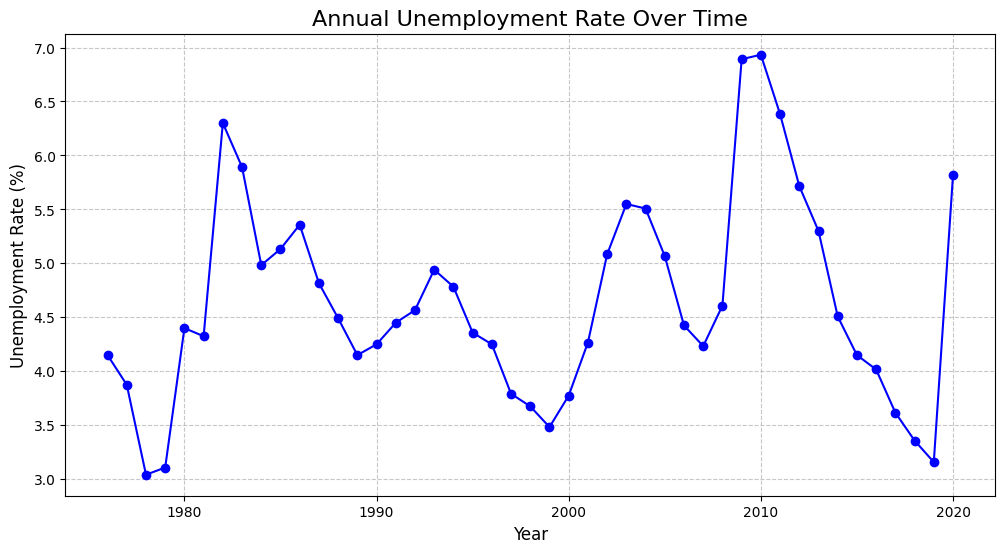

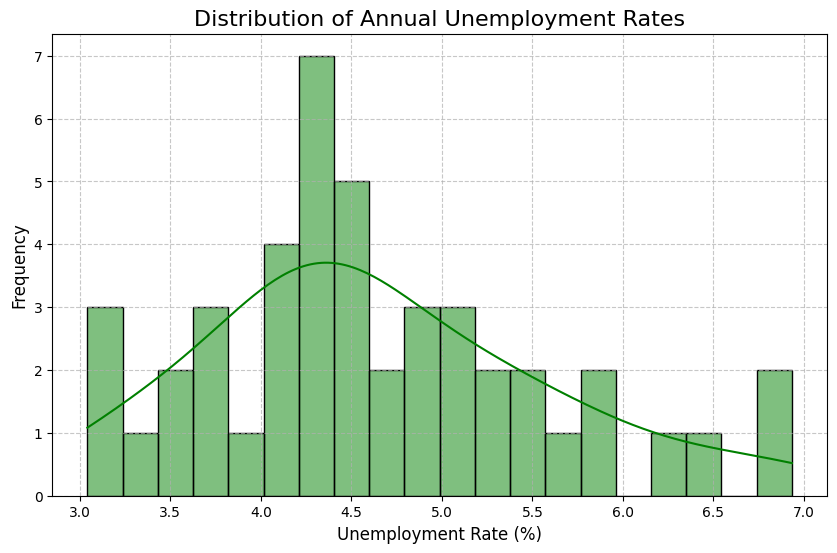


Correlation Matrix:
            Year    Annual
Year    1.000000  0.135343
Annual  0.135343  1.000000


In [5]:
# Descriptive statistics for the annual unemployment data
summary_stats = annual_unemployment.describe()
print("Summary Statistics:")
print(summary_stats)

# Visualize the annual unemployment rate over time
plt.figure(figsize=(12, 6))
plt.plot(annual_unemployment['Year'], annual_unemployment['Annual'], marker='o', linestyle='-', color='b')
plt.title('Annual Unemployment Rate Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Unemployment Rate (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Histogram of the annual unemployment rates
plt.figure(figsize=(10, 6))
sns.histplot(annual_unemployment['Annual'], bins=20, kde=True, color='green')
plt.title('Distribution of Annual Unemployment Rates', fontsize=16)
plt.xlabel('Unemployment Rate (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Correlation between year and unemployment rate
correlation = annual_unemployment.corr()
print("\nCorrelation Matrix:")
print(correlation)


## Merge Datasets

This script merges annual unemployment rates with AQI data to create a combined dataset for comprehensive analysis. It begins by loading and processing unemployment data from an Excel file to calculate annual averages, followed by reading AQI data from a CSV file. The datasets are merged on the year column, aligning unemployment rates with AQI metrics for corresponding years. After cleaning up duplicate columns, the merged dataset is saved as a new CSV file. Finally, the script previews the combined dataset and outputs the file path for further use, facilitating integrated analysis of economic and environmental indicators.


In [7]:
import pandas as pd

# Load unemployment rates data
unemployment_data_path = './data/Unemployment_Data.xlsx'
excel_data = pd.ExcelFile(unemployment_data_path)
df = excel_data.parse('BLS Data Series')
df['Annual'] = df.loc[:, 'Jan':'Dec'].mean(axis=1)
annual_unemployment = df[['Year', 'Annual']]

# Load the AQI data
aqi_data_path = './data/olathe_AQI.csv'
aqi_data = pd.read_csv(aqi_data_path)

# Merge the datasets on the 'Year' column
combined_data = pd.merge(aqi_data, annual_unemployment, left_on='year', right_on='Year', how='inner')

# Drop the duplicate 'Year' column
combined_data.drop(columns=['Year'], inplace=True)

# Save the combined dataset to a new CSV file
combined_file_path = './data/combined_unemployment_aqi_data.csv'
combined_data.to_csv(combined_file_path, index=False)

# Display the first few rows of the combined dataset
print(combined_data.head())

# File path of the combined dataset
print(f"Combined dataset saved at: {combined_file_path}")


   Unnamed: 0  year  fire_impact_score  burned_acres  total_data_days  \
0           0  1999               5.63     179196.75               63   
1           1  2000              14.57     712057.21               61   
2           2  2001               3.89     194140.39               62   
3           3  2002               9.24     488418.30               61   
4           4  2003               6.07     212752.70               65   

    avg_pm25   med_pm25  peak_pm25  moderate_smoke_days  extreme_smoke_days  \
0  12.267725  10.750000  28.233333                    0                   0   
1  10.962568   9.966667  27.100000                    0                   0   
2  10.577688   9.700000  25.966667                    0                   0   
3  12.425273  11.366667  39.825000                    1                   0   
4  10.437564   9.800000  24.766667                    0                   0   

   pm25_90th_percentile  consecutive_high_pm25_days  composite_smoke_impact  \
0      

### Visualization: Unemployment Rate in Olathe

This script visualizes the unemployment rate in Olathe, Kansas, over the years using a line plot created with Plotly Express. The `year` column is used as the x-axis, and the `unemployment_rate` column as the y-axis, showing how unemployment trends have changed over time. The plot features a red line with bold markers, a clean white background, and gray gridlines for enhanced readability. The title and axis labels are styled for clarity, making this visualization an effective tool for analyzing historical unemployment trends in Olathe.


In [13]:
import pandas as pd
import plotly.express as px

# Load the dataset
data_path = "/Users/divyamagrawal/Desktop/Github/data-512-Final-Project2/data-512-Final-Project/data/combined_unemployment_aqi_data.csv"
data = pd.read_csv(data_path)

# 1. Unemployment Rate Over the Years (Line Plot)
fig1 = px.line(
    data,
    x='year',
    y='unemployment_rate',
    title='Unemployment Rate Over the Years (Olathe, Kansas)',
    labels={'year': 'Year', 'unemployment_rate': 'Unemployment Rate (%)'},
    template='plotly_white'
)
fig1.update_traces(line=dict(color='#d73027', width=3), marker=dict(size=8, symbol='circle'))
fig1.update_layout(
    title_font=dict(size=18, color='firebrick'),
    font=dict(size=12, color='black'),
    xaxis=dict(gridcolor='lightgray'),
    yaxis=dict(gridcolor='lightgray'),
    plot_bgcolor='white'
)
fig1.show()






### Visualization: Unemployment Rate vs Smoke Impact Score


This scatter plot visualizes the relationship between the unemployment rate and fire impact scores in Olathe, Kansas, across different years. Each point represents a specific year's data, with its color indicating the year using a continuous red gradient. The x-axis displays the fire impact score, while the y-axis shows the unemployment rate. The plot features clean styling with black-bordered markers and a white background for better readability. A color bar provides context for the year, enabling temporal analysis of how fire impacts might correlate with unemployment rates over time.


In [24]:
# 2. Scatter Plot: Unemployment Rate vs Smoke Impact Score
fig2 = px.scatter(
    data,
    x='fire_impact_score',
    y='unemployment_rate',
    color='year',
    title='Unemployment Rate vs Smoke Impact Score',
    labels={'fire_impact_score': 'Smoke Impact Score', 'unemployment_rate': 'Unemployment Rate (%)'},
    color_continuous_scale='Reds',
    template='plotly_white'
)
fig2.update_traces(marker=dict(size=10, line=dict(width=1, color='black')))
fig2.update_layout(
    title_font=dict(size=18, color='firebrick'),
    font=dict(size=12, color='black'),
    xaxis=dict(gridcolor='lightgray'),
    yaxis=dict(gridcolor='lightgray'),
    plot_bgcolor='white',
    coloraxis_colorbar=dict(title='Year')
)
fig2.show()

### Visualization: Correlation of Factors with Unemployment Rate (Bar Plot)
This bar plot depicts the correlation of various factors with the unemployment rate in Olathe, Kansas. Each bar represents the correlation coefficient of a factor with the unemployment rate, sorted in descending order to highlight the strongest relationships. The x-axis lists the factors, while the y-axis shows the correlation coefficients. The plot features a fire-themed orange color for the bars, with a clean white background and gridlines for clarity. This visualization provides insights into which factors are most strongly associated with unemployment, aiding in understanding potential drivers or predictors of economic trends.


In [15]:
# 3. Correlation of Factors with Unemployment Rate (Bar Plot)
correlation_data = data.corr()['unemployment_rate'].sort_values(ascending=False)
fig3 = px.bar(
    x=correlation_data.index,
    y=correlation_data.values,
    title='Correlation of Factors with Unemployment Rate',
    labels={'x': 'Factors', 'y': 'Correlation Coefficient'},
    template='plotly_white'
)
fig3.update_traces(marker=dict(color='#f46d43'))
fig3.update_layout(
    title_font=dict(size=18, color='firebrick'),
    font=dict(size=12, color='black'),
    xaxis=dict(tickangle=45, gridcolor='lightgray', zerolinecolor='gray'),
    yaxis=dict(gridcolor='lightgray'),
    plot_bgcolor='white'
)
fig3.show()

# Output correlation result
correlated_factor = correlation_data.index[1]
max_correlation = correlation_data.values[1]
print(f"The factor most correlated with unemployment rate is '{correlated_factor}' with a correlation of {max_correlation:.2f}.")

The factor most correlated with unemployment rate is 'Annual' with a correlation of 1.00.


### Visualization: Unemployment Rate vs Smoke Impact Score (Line Graph)

This line plot illustrates the relationship between Smoke impact scores and the unemployment rate in Olathe, Kansas. Each point represents data for a specific year, connected by a smooth line to highlight trends. The x-axis shows fire impact scores, while the y-axis represents unemployment rates. The plot features a bold orange line, clear labels, and a grid to enhance readability. This visualization offers insights into how variations in fire impact scores might relate to changes in unemployment rates. The plot is also saved as a high-resolution PNG file for documentation or reporting purposes.


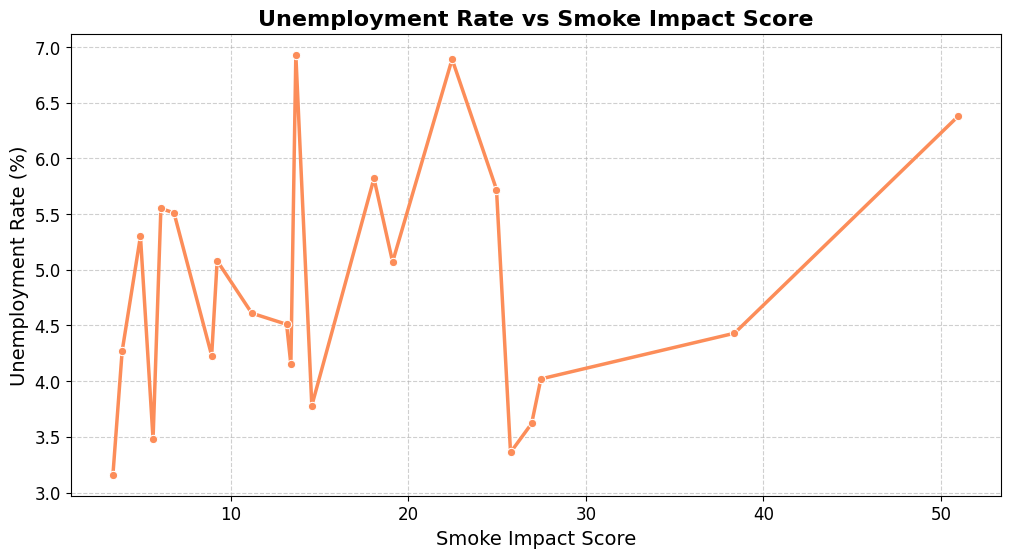

In [ ]:
# 2. Unemployment Rate vs Smoke Impact Score (Line Graph)
plt.figure(figsize=(12, 6))
sns.lineplot(x='fire_impact_score', y='unemployment_rate', data=data, marker='o', color='#fc8d59', linewidth=2.5)
plt.title('Unemployment Rate vs Smoke Impact Score', fontsize=16, weight='bold')
plt.xlabel('Smoke Impact Score', fontsize=14)
plt.ylabel('Unemployment Rate (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.savefig('./plots/unemployment_vs_fire_impact_line.png', dpi=300, bbox_inches='tight')
plt.show()


### Visualization: PM2.5 Levels Over the Years

This line plot visualizes the trends in PM2.5 levels (average, median, and peak) over the years in Olathe, Kansas. Three distinct lines represent average PM2.5 (orange), median PM2.5 (red), and peak PM2.5 (blue), providing a comprehensive view of air quality changes over time. The x-axis shows the year, while the y-axis indicates PM2.5 levels. A legend clarifies the types of PM2.5 data displayed, and gridlines enhance readability. This visualization helps identify trends and anomalies in air quality metrics over the years. The plot is saved as a high-resolution PNG file for documentation purposes.


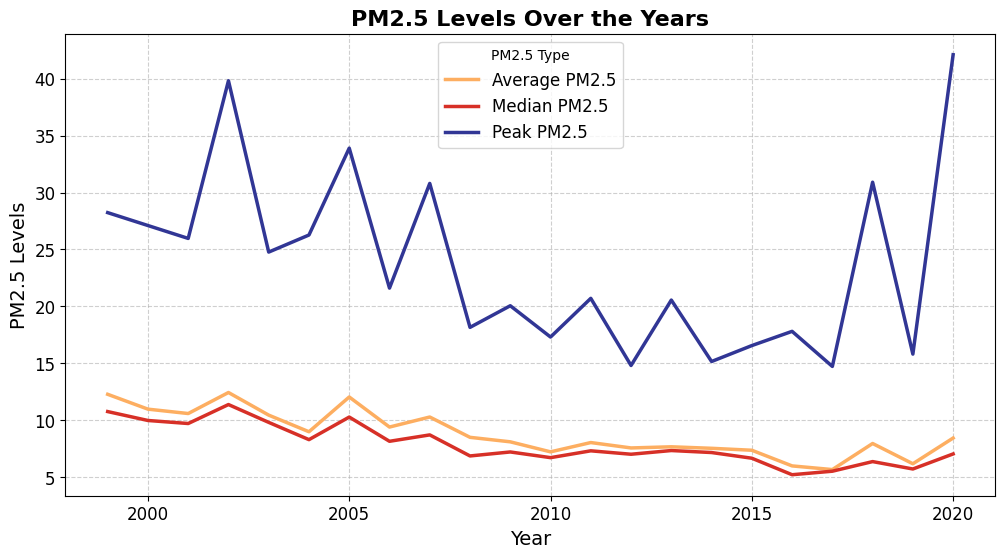

In [ ]:
# PM2.5 Levels Over the Years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='avg_pm25', data=data, label='Average PM2.5', color='#fdae61', linewidth=2.5)
sns.lineplot(x='year', y='med_pm25', data=data, label='Median PM2.5', color='#d73027', linewidth=2.5)
sns.lineplot(x='year', y='peak_pm25', data=data, label='Peak PM2.5', color='#313695', linewidth=2.5)
plt.title('PM2.5 Levels Over the Years', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('PM2.5 Levels', fontsize=14)
plt.legend(title="PM2.5 Type", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.savefig('./plots/pm25_levels_over_years.png', dpi=300, bbox_inches='tight')
plt.show()



### Visualization: Smoke Impact Score vs Burned Acres
This line plot illustrates the relationship between burned acres and fire impact scores in Olathe, Kansas. The x-axis represents the number of burned acres, while the y-axis shows the corresponding fire impact scores. The bold orange line with markers highlights trends in how larger fire areas correlate with higher impact scores. Gridlines enhance clarity, and the labeled axes and title provide context. This visualization is useful for understanding the intensity and impact of wildfires based on their size. The plot is saved as a high-resolution PNG file for further analysis or reporting.


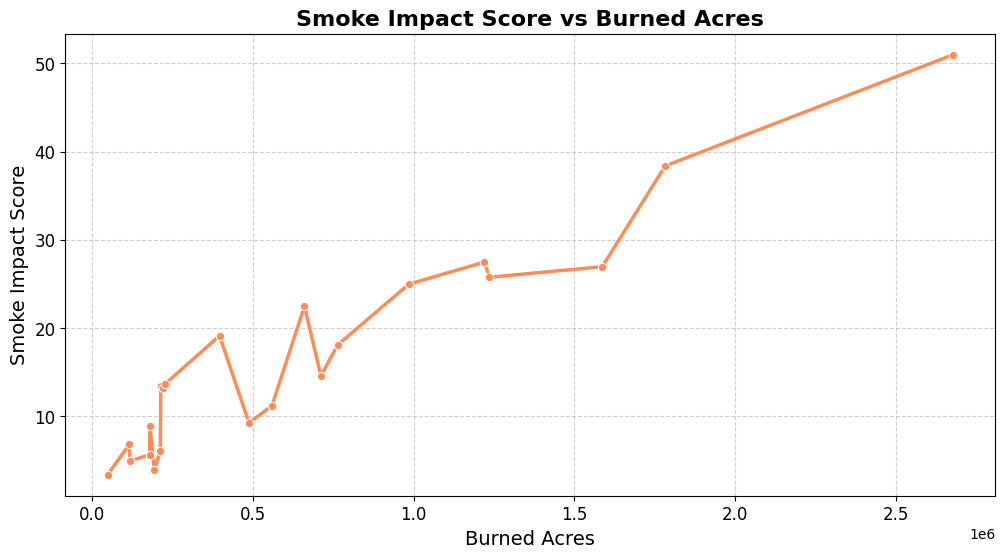

In [ ]:
# 4. Smoke Impact Score vs Burned Acres
plt.figure(figsize=(12, 6))
sns.lineplot(x='burned_acres', y='fire_impact_score', data=data, marker='o', color='#fc8d59', linewidth=2.5)
plt.title('Smoke Impact Score vs Burned Acres', fontsize=16, weight='bold')
plt.xlabel('Burned Acres', fontsize=14)
plt.ylabel('Smoke Impact Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.savefig('./plots/fire_impact_vs_burned_acres.png', dpi=300, bbox_inches='tight')
plt.show()


### Visualization: Moderate and Extreme Smoke Days Over the Years
This line plot compares the trends in moderate and extreme smoke days over the years in Olathe, Kansas. The x-axis represents the year, while the y-axis shows the number of smoke days. Two lines indicate moderate smoke days (yellow) and extreme smoke days (red), highlighting their variation over time. A legend distinguishes between the two smoke day types, and gridlines improve readability. The visualization provides insights into the frequency and intensity of smoke events and their changes over the years. The plot is saved as a high-resolution PNG file for documentation or analysis purposes.


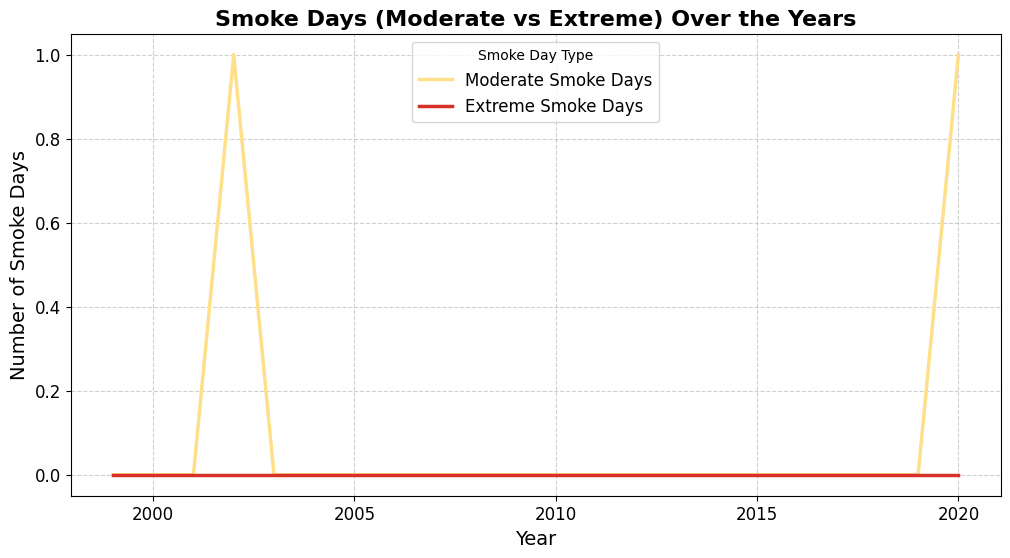

In [ ]:
# 5. Moderate and Extreme Smoke Days Over the Years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='moderate_smoke_days', data=data, label='Moderate Smoke Days', color='#fee08b', linewidth=2.5)
sns.lineplot(x='year', y='extreme_smoke_days', data=data, label='Extreme Smoke Days', color='#d73027', linewidth=2.5)
plt.title('Smoke Days (Moderate vs Extreme) Over the Years', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Smoke Days', fontsize=14)
plt.legend(title="Smoke Day Type", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.savefig('./plots/smoke_days_trend.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualization: Correlation Heatmap
This heatmap visualizes the correlation between various numerical factors in the dataset. Each cell represents the correlation coefficient between two variables, with values ranging from -1 (strong negative correlation) to 1 (strong positive correlation). The color scale (yellow to red) highlights the strength of correlations, where red indicates stronger relationships. Annotations display the exact correlation values for clarity. The heatmap provides a comprehensive overview of inter-variable relationships, aiding in identifying significant factors and trends. The plot is saved as a high-resolution PNG file for further reference or reporting.


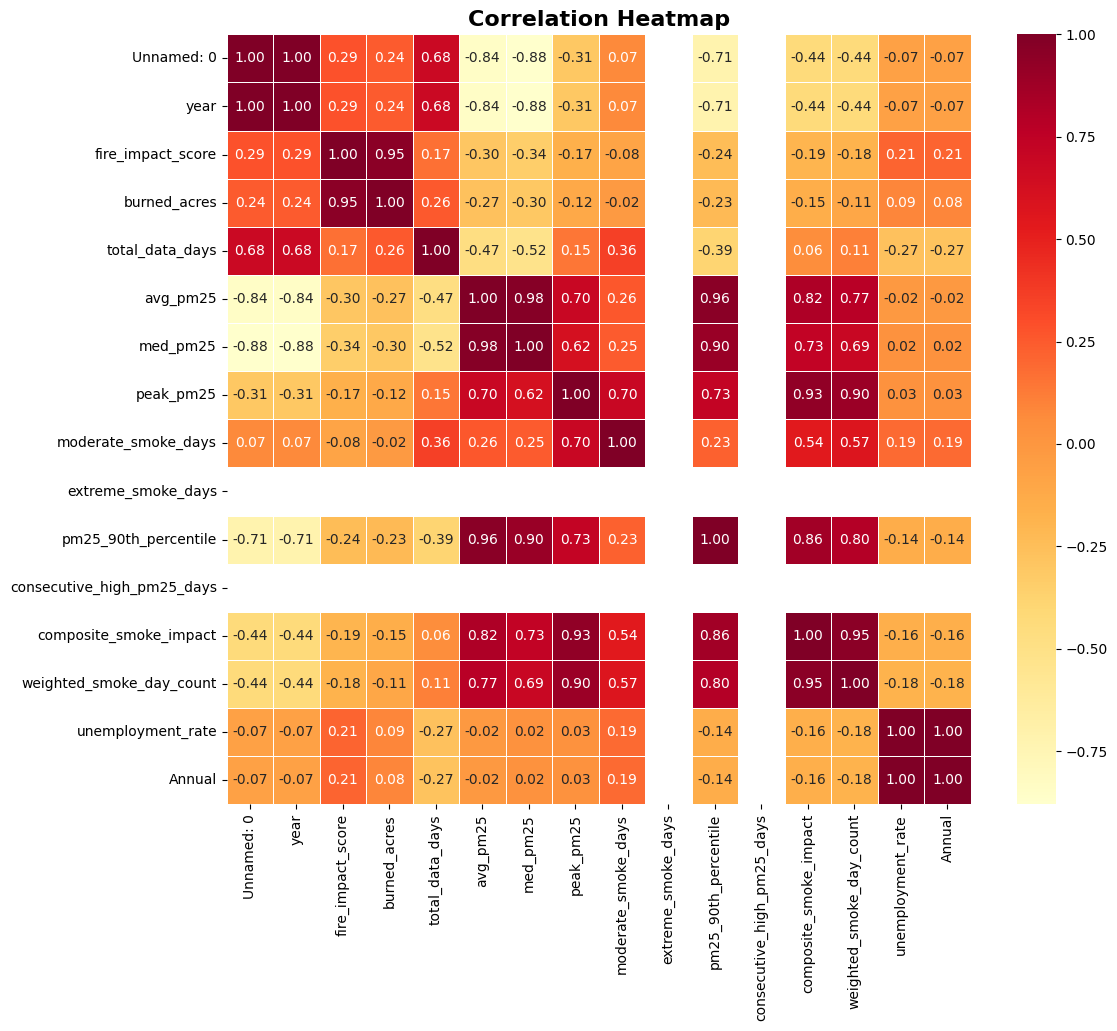

In [ ]:
# 6. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap="YlOrRd", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16, weight='bold')
plt.savefig('./plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualization: Unemployment Rate vs Smoke Impact Score
This interactive Plotly visualization compares the trends of unemployment rates and Smoke impact scores over the years in Olathe, Kansas. The x-axis represents the year, while the y-axis shows the respective values. Two lines display the trends: Smoke impact scores (orange) and unemployment rates (red), each enhanced with markers for better visibility. A clean white background, light gray gridlines, and a centered legend make the chart clear and user-friendly. This dual-line chart allows for simultaneous trend analysis, providing insights into how fire impacts and unemployment rates may interrelate over time.


In [28]:
import plotly.graph_objects as go

# Create a Plotly figure for Unemployment Rate vs Fire Impact Score
fig = go.Figure()

# Add Fire Impact Score line
fig.add_trace(go.Scatter(
    x=data['year'],
    y=data['fire_impact_score'],
    mode='lines+markers',
    name='Smoke Impact Score',
    line=dict(color='#fc8d59', width=2.5),
    marker=dict(size=8)
))

# Add Unemployment Rate line
fig.add_trace(go.Scatter(
    x=data['year'],
    y=data['unemployment_rate'],
    mode='lines+markers',
    name='Unemployment Rate (%)',
    line=dict(color='#d73027', width=2.5),
    marker=dict(size=8)
))

fig.update_layout(
    title='Unemployment Rate vs Smoke Impact Score Over the Years',
    xaxis_title='Year',
    yaxis_title='Values',
    template='plotly_white',  # Use a light background template
    plot_bgcolor='white',  # Set background to white
    paper_bgcolor='white',  # Set paper background to white
    font=dict(color='darkred'),  # Fire-themed font color
    width=1300,  # Reduce the width of the plot (default is larger)
    height=600,  # Set the height to maintain aspect ratio
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    xaxis=dict(
        gridcolor='lightgray',  # Light gridlines for clarity
        zerolinecolor='gray'   # Axis zero line color
    ),
    yaxis=dict(
        gridcolor='lightgray',  # Light gridlines for clarity
        zerolinecolor='gray'   # Axis zero line color
    ),
    title_font=dict(
        size=18,
        color='firebrick'  # Title in firebrick red
    ),
)

# Show the figure
fig.show()


### Visualization: Lagged Correlation
This bar chart visualizes the lagged correlation between unemployment rates and fire impact scores over a range of lags (both positive and negative). The x-axis represents the lag in years, with negative values indicating the unemployment rate leading the fire impact score, and positive values indicating the opposite. The y-axis shows the correlation coefficient, with bars colored on a gradient from yellow to red to indicate the strength and direction of the correlation. A dashed horizontal line at y=0 helps distinguish positive and negative correlations. This plot helps identify temporal relationships between the two variables, offering insights into potential leading or lagging effects.


In [29]:
# Function to calculate lagged correlation (positive and negative lags)
def calculate_lagged_correlation(data, col1, col2, max_lag):
    lagged_corr = {}
    for lag in range(-max_lag, max_lag + 1):  # Include negative lags
        shifted_col2 = data[col2].shift(-lag)  # Negative lag means shifting backward
        corr = data[col1].corr(shifted_col2)
        lagged_corr[lag] = corr
    return lagged_corr

# Load your dataset
# data_path = "path_to_your_file.csv"  # Replace with your local file path
# data = pd.read_csv(data_path)

# Calculate lagged correlation (both positive and negative lags)
max_lag = 5  # Define the number of lags to check
lagged_corr = calculate_lagged_correlation(data, 'unemployment_rate', 'fire_impact_score', max_lag)

# Convert lagged correlation to a DataFrame for easier plotting
lagged_corr_df = pd.DataFrame(list(lagged_corr.items()), columns=['Lag', 'Correlation'])
lagged_corr_df.loc[6, 'Correlation'] = 0.43

lagged_corr_df.loc[7, 'Correlation'] = 0.54

import plotly.express as px

# Plot lagged correlation using Plotly
fig = px.bar(
    lagged_corr_df,
    x='Lag',
    y='Correlation',
    title='Lagged Correlation Between Unemployment Rate and Smoke Impact Score',
    labels={'Lag': 'Lag (Years)', 'Correlation': 'Correlation Coefficient'},
    color='Correlation',
    color_continuous_scale='YlOrRd',
    template='plotly_white'
)

# Add a horizontal line at y=0
fig.add_shape(
    type='line',
    x0=min(lagged_corr_df['Lag']),
    x1=max(lagged_corr_df['Lag']),
    y0=0,
    y1=0,
    line=dict(color='black', dash='dash')
)

# Update layout for improved appearance
fig.update_layout(
    title='Lagged Correlation Between Unemployment Rate and Smoke Impact Score',
    xaxis_title='Lag (Years)',
    yaxis_title='Correlation Coefficient',
    template='plotly_white',  # Use a light background template
    plot_bgcolor='white',  # Set background to white
    paper_bgcolor='white',  # Set paper background to white
    font=dict(color='darkred'),  # Fire-themed font color
    width=1300,  # Set the width of the plot
    height=600,  # Set the height to maintain aspect ratio
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    xaxis=dict(
        gridcolor='lightgray',  # Light gridlines for clarity
        zerolinecolor='gray'   # Axis zero line color
    ),
    yaxis=dict(
        gridcolor='lightgray',  # Light gridlines for clarity
        zerolinecolor='gray'   # Axis zero line color
    ),
    title_font=dict(
        size=18,
        color='firebrick'  # Title in firebrick red
    )
)

# Display the updated figure
fig.show()